# Recommender Systems Challenge, 2023/2024 @ PoliMi

# Introduction

## Problem Description
The application domain is book recommendation. The datasets contain interactions of users with books, in particular, if the user attributed to the book a rating of at least 4. The main goal of the competition is to discover which items (books) a user will interact with.

The datasets includes around 600k interactions, 13k users, 22k items (books).
The training-test split is done via random holdout, 80% training, 20% test.
The goal is to recommend a list of 10 potentially relevant items for each user.


## Datasets
All files are comma-separated (columns are separated with ',' ).

- **data_train.csv**:
Contains the training set, describing implicit preferences expressed by the users.
    - **user_id** : identifier of the user
    - **item_id** : identifier of the item (Book)
    - **data** : "1.0" if the user liked the book attributing it a rating of at least 4.


- **data_target_users_test.csv**:
Contains the ids of the users that should appear in your submission file.
The submission file should contain all and only these users.

- **sample_submission.csv**:
A sample submission file in the correct format: [user_id],[ordered list of recommended items].
Be careful with the spaces and be sure to recommend the correct number of items to every user.

# Requirements

The working environment and the required libraries are defined here.

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps # creation of sparse matrix
import matplotlib.pyplot as pyplot # plot

from tqdm import tqdm

from scipy.stats import uniform, loguniform
import optuna as op
import xgboost as xgb
from xgboost import XGBRanker

In [2]:
%load_ext Cython

# Data Preprocessing

In [3]:
# Handle the input file
input_file = open('Input/data_train.csv', 'r')
type(input_file)

_io.TextIOWrapper

In [4]:
# Build the dataframe from the input file
input_df = pd.read_csv(
    filepath_or_buffer=input_file,
    dtype={0:int, 1:int, 2:int},
    names=['user_id','item_id','data'],
    header=0
)

input_df.shape

(478730, 3)

In [5]:
input_df.drop_duplicates()
input_df.shape

(478730, 3)

In [6]:
# Show the first rows of the dataframe
input_df.head(n=10)

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [7]:
# Create arrays of unique user_ids and item_ids
arr_users = input_df["user_id"].unique()
arr_items = input_df["item_id"].unique()

print(arr_users)
print(arr_items)

[    1     2     3 ... 13022 13023 13024]
[    7    15    16 ... 22317 22339 21466]


In [8]:
# Show some statistics
n_users = len(arr_users)
n_items = len(arr_items)
n_interactions = len(input_df)

print("Average interaction per user {:.2f}".format(n_interactions/n_users))
print("Average interaction per item {:.2f}".format(n_interactions/n_items))
print("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Average interaction per user 37.88
Average interaction per item 21.54
Sparsity 99.83 %


In [9]:
print("Number of users\t {}, Number of items\t {} \n".format(n_users, n_items))
print("Max ID users\t {}, Max ID items\t {} \n".format(max(arr_users), max(arr_items)))

Number of users	 12638, Number of items	 22222 

Max ID users	 13024, Max ID items	 22347 



In [10]:
# # Remove empty indices, create a new mapping

# mapped_id, original_id = pd.factorize(input_df["user_id"].unique())
# user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

# mapped_id, original_id = pd.factorize(input_df["item_id"].unique())
# item_original_ID_to_index = pd.Series(mapped_id, index=original_id)


# original_item_ID = 980
# print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))

In [11]:
# # Replace the IDs in the dataframe

# input_df["user_id"] = input_df["user_id"].map(user_original_ID_to_index)
# input_df["item_id"] = input_df["item_id"].map(item_original_ID_to_index)


# input_df.head(n=10)

# Matrix Conversion

In [12]:
# Build the COO matrix with the COO constructor: (data, (row, column))
URM_all = sps.coo_matrix(
    (input_df["data"].values,
    (input_df["user_id"].values, input_df["item_id"].values))
)

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.int32'>'
	with 478730 stored elements in COOrdinate format>

In [13]:
# Convert the matrix to Compressed Sparse Row format
URM_all = URM_all.tocsr()

URM_all

<13025x22348 sparse matrix of type '<class 'numpy.intc'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [14]:
# Compute the item popularity as the number of interaction in each column

# numpy.ediff1d(): calculate the differences between consecutive elements of an array.
# (scipy) indptr maps the elements of data and indices to the rows of the sparse matrix.
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([   0, 1581, 1764, ...,    3,    5,    2])

In [15]:
# Sort the popularity array
item_popularity = np.sort(item_popularity)
item_popularity

array([   0,    0,    0, ..., 1581, 1666, 1764])

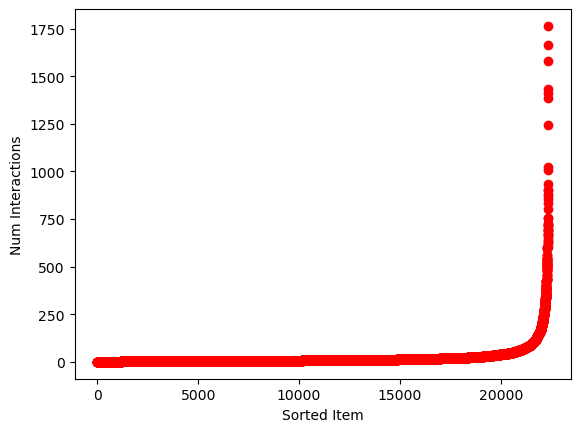

In [16]:
# Plot the correlation between sorted items and the number of interactions.
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [17]:
# Statistics
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Average per-item interactions over the whole dataset 21.42
Average per-item interactions for the top 10% popular items 122.73
Average per-item interactions for the least 10% popular items 2.18
Average per-item interactions for the median 10% popular items 8.25
Number of items with zero interactions 126


In [18]:
# Compute the user activity as the number of interaction in each row
user_activity = np.ediff1d(URM_all.indptr)
user_activity = np.sort(user_activity)
user_activity

array([   0,    0,    0, ...,  729,  824, 1351])

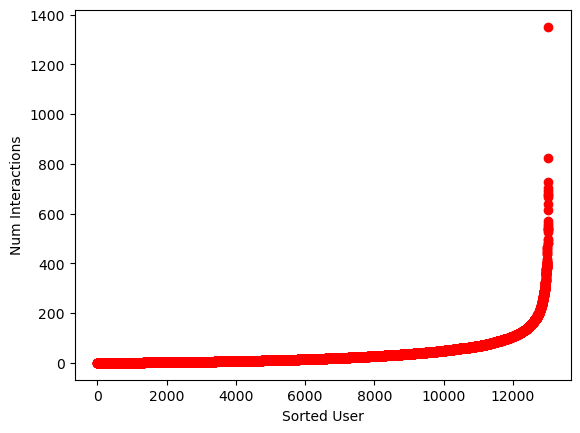

In [19]:
# Plot the correlation between sorted users and number of interactions
pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions')
pyplot.xlabel('Sorted User')
pyplot.show()

# Evaluation of the recommender

In [20]:
# Define the train-test splitting ratio
train_test_split = 0.85

In [21]:
# Import Evaluators
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [ ]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = train_test_split)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = train_test_split)

In [22]:
# Or load from existing dataframe
URM_train = sps.load_npz('Input/train10.npz')
URM_train

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 406920 stored elements in Compressed Sparse Row format>

In [23]:
URM_test = sps.load_npz('Input/test10.npz')
URM_test

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 71810 stored elements in Compressed Sparse Row format>

In [24]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 3145 (24.1%) Users that have less than 1 test interactions


Content-based: URM in csr, ICM in csr

Collaborative filtering: URM in csr

FunkSVD: URM in coo

AsySVD: URM in coo


## Best Recommenders after tuning

In [25]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
slime = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
slime.fit(l1_ratio=0.05223, alpha=0.00116885, topK=451)

SLIMElasticNetRecommender: URM Detected 523 ( 4.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 219 ( 1.0%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22344/22348 [02:10<00:00, 171.10it/s]


In [30]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemknncf = ItemKNNCFRecommender(URM_train)
itemknncf.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 523 ( 4.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 219 ( 1.0%) items with no interactions.
Similarity column 22348 (100.0%), 11466.59 column/sec. Elapsed time 1.95 sec


In [31]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
p3alpha = P3alphaRecommender(URM_train)
p3alpha.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 523 ( 4.0%) users with no interactions.
P3alphaRecommender: URM Detected 219 ( 1.0%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 6463.99 column/sec. Elapsed time 3.46 sec


In [32]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
rp3beta = RP3betaRecommender(URM_train)
rp3beta.fit(topK=25, alpha=0.26339, beta=0.20854, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 523 ( 4.0%) users with no interactions.
RP3betaRecommender: URM Detected 219 ( 1.0%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 6308.39 column/sec. Elapsed time 3.54 sec


In [33]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
ease = EASE_R_Recommender(URM_train)
ease.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 523 ( 4.0%) users with no interactions.
EASE_R_Recommender: URM Detected 219 ( 1.0%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.36 min


In [34]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
userknncf = UserKNNCFRecommender(URM_train)
userknncf.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 523 ( 4.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 219 ( 1.0%) items with no interactions.
Similarity column 13025 (100.0%), 10293.82 column/sec. Elapsed time 1.27 sec


In [35]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity
sim1 = Compute_Similarity(URM_train, shrink = 9.803724, topK = 62, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_train, shrink = 6.736, topK = 3, similarity = 'jaccard').compute_similarity()
itemhybrid = ItemKNNSimilarityHybridRecommender(URM_train, sim1, sim2)
itemhybrid.fit(topK = 36, alpha = 0.267625)

Similarity column 22348 (100.0%), 11247.28 column/sec. Elapsed time 1.99 sec
Similarity column 22348 (100.0%), 10413.79 column/sec. Elapsed time 2.15 sec
ItemKNNSimilarityHybridRecommender: URM Detected 523 ( 4.0%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 219 ( 1.0%) items with no interactions.


In [36]:
from Recommenders.ScoresHybridRecommender3 import ScoresHybridRecommender3
recommender = ScoresHybridRecommender3(URM_train, slime, itemhybrid, rp3beta)
recommender.fit(alpha=0.661077, beta=0.144166)

ScoresHybridRecommender3: URM Detected 523 ( 4.0%) users with no interactions.
ScoresHybridRecommender3: URM Detected 219 ( 1.0%) items with no interactions.


## XGBoost

In [37]:
from Recommenders.Recommender_import_list import *

C:\Users\zheng\.conda\envs\RecSysFramework\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [126]:
candidate_generator_recommender = recommender

In [127]:
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["item_id"])
training_dataframe.index.name='user_id'

In [128]:
training_dataframe

,item_id
user_id,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13020,NaN
13021,NaN
13022,NaN


In [129]:
cutoff = 50

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "item_id"] = recommendations

100%|██████████████████████████████████████████████████████████████████████████| 13025/13025 [00:10<00:00, 1220.17it/s]


In [130]:
training_dataframe

,item_id
user_id,
0,"[14886, 14901, 14900, 14899, 14898, 14897, 148..."
1,"[36, 101, 123, 403, 506, 515, 694, 1481, 1338,..."
2,"[1095, 47, 1372, 12, 50, 11, 112, 196, 102, 13..."
3,"[59, 857, 2748, 3152, 1895, 2172, 956, 584, 25..."
4,"[27, 28, 249, 252, 7, 314, 50, 5, 171, 254, 13..."
...,...
13020,"[6198, 6450, 7056, 6451, 6452, 6749, 6197, 572..."
13021,"[148, 6451, 6426, 6720, 7369, 7055, 304, 6179,..."
13022,"[1668, 1674, 1411, 1446, 809, 10789, 8100, 384..."


In [131]:
training_dataframe = training_dataframe.explode("item_id")
training_dataframe

,item_id
user_id,
0,14886
0,14901
0,14900
0,14899
0,14898
...,...
13024,10125
13024,24
13024,1069


In [132]:
URM_validation=URM_test

In [133]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"user_id": URM_validation_coo.row,
                                        "item_id": URM_validation_coo.col})
correct_recommendations

,user_id,item_id
0,1,16
1,1,377
2,1,544
3,1,1935
4,1,2462
...,...,...
71805,13024,3495
71806,13024,4428
71807,13024,7824
71808,13024,10204


In [134]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['user_id','item_id'], how='left', indicator='Exist')
training_dataframe

,user_id,item_id,Exist
0,0,14886,left_only
1,0,14901,left_only
2,0,14900,left_only
3,0,14899,left_only
4,0,14898,left_only
...,...,...,...
651245,13024,10125,left_only
651246,13024,24,left_only
651247,13024,1069,left_only
651248,13024,696,left_only


In [135]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,user_id,item_id,Label
0,0,14886,False
1,0,14901,False
2,0,14900,False
3,0,14899,False
4,0,14898,False
...,...,...,...
651245,13024,10125,False
651246,13024,24,False
651247,13024,1069,False
651248,13024,696,False


In [136]:
topPop = TopPop(URM_train)
topPop.fit()

TopPopRecommender: URM Detected 523 ( 4.0%) users with no interactions.
TopPopRecommender: URM Detected 219 ( 1.0%) items with no interactions.


In [137]:
other_algorithms = {
    "TopPop": topPop,
    "ItemKNNCF": itemknncf,
    "P3alpha": p3alpha,
    "RP3beta": rp3beta,
    "SLIM-E": slime,
    "EASE_R": ease,
    "UserKNNCF": userknncf,
    "ItemHybrid": itemhybrid,
}

In [138]:
training_dataframe = training_dataframe.set_index('user_id')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "user_id"})
training_dataframe

100%|███████████████████████████████████████████████████████████████████████████| 13025/13025 [00:40<00:00, 318.49it/s]


,user_id,item_id,Label,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,0,14886,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,14901,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,14900,False,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,14899,False,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,14898,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
651245,13024,10125,False,9.0,0.255285,0.043667,0.067852,0.098157,0.072344,1.332146,0.455006
651246,13024,24,False,570.0,0.256824,0.000000,0.000000,0.129597,0.000000,3.041317,0.389825
651247,13024,1069,False,72.0,0.240426,0.061309,0.090716,0.115235,0.105858,4.787150,0.319857
651248,13024,696,False,87.0,0.204475,0.000000,0.000000,0.138367,0.000000,5.042644,0.302819


In [139]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["item_id"].values.astype(int)]
training_dataframe

,user_id,item_id,Label,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity
0,0,14886,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
1,0,14901,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7
2,0,14900,False,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
3,0,14899,False,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
4,0,14898,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...
651245,13024,10125,False,9.0,0.255285,0.043667,0.067852,0.098157,0.072344,1.332146,0.455006,9
651246,13024,24,False,570.0,0.256824,0.000000,0.000000,0.129597,0.000000,3.041317,0.389825,570
651247,13024,1069,False,72.0,0.240426,0.061309,0.090716,0.115235,0.105858,4.787150,0.319857,72
651248,13024,696,False,87.0,0.204475,0.000000,0.000000,0.138367,0.000000,5.042644,0.302819,87


In [140]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["user_id"].values.astype(int)]
training_dataframe

,user_id,item_id,Label,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,14886,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
1,0,14901,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
2,0,14900,False,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
3,0,14899,False,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
4,0,14898,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651245,13024,10125,False,9.0,0.255285,0.043667,0.067852,0.098157,0.072344,1.332146,0.455006,9,59
651246,13024,24,False,570.0,0.256824,0.000000,0.000000,0.129597,0.000000,3.041317,0.389825,570,59
651247,13024,1069,False,72.0,0.240426,0.061309,0.090716,0.115235,0.105858,4.787150,0.319857,72,59
651248,13024,696,False,87.0,0.204475,0.000000,0.000000,0.138367,0.000000,5.042644,0.302819,87,59


## After adding features

In [142]:
training_dataframe = training_dataframe.set_index('user_id')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": 'user_id'})
training_dataframe

,user_id,item_id,Label,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,14886,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
1,0,14901,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
2,0,14900,False,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
3,0,14899,False,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
4,0,14898,False,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651245,13024,10125,False,9.0,0.255285,0.043667,0.067852,0.098157,0.072344,1.332146,0.455006,9,59
651246,13024,24,False,570.0,0.256824,0.000000,0.000000,0.129597,0.000000,3.041317,0.389825,570,59
651247,13024,1069,False,72.0,0.240426,0.061309,0.090716,0.115235,0.105858,4.787150,0.319857,72,59
651248,13024,696,False,87.0,0.204475,0.000000,0.000000,0.138367,0.000000,5.042644,0.302819,87,59


In [143]:
training_dataframe = training_dataframe.sort_values("user_id").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,user_id,item_id,Label,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,14886,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
1,0,14926,False,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
2,0,14925,False,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,0
3,0,14924,False,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,0
4,0,14923,False,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651245,13024,11058,True,13.0,0.300752,0.086007,0.162755,0.198510,0.088448,5.069626,0.716538,13,59
651246,13024,554,True,113.0,0.366370,0.064209,0.133706,0.263935,0.296763,5.176641,0.406508,113,59
651247,13024,9590,False,10.0,0.729179,0.120036,0.181075,0.196558,0.151942,3.946443,0.645834,10,59
651248,13024,9059,False,13.0,0.540476,0.136707,0.224997,0.235551,0.141614,4.291100,0.942295,13,59


In [144]:
groups = training_dataframe.groupby("user_id").size().values
groups

array([50, 50, 50, ..., 50, 50, 50], dtype=int64)

In [145]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

In [146]:
X_train["user_id"] = X_train["user_id"].astype("category")
X_train["item_id"] = X_train["item_id"].astype("category")

In [147]:
n_estimators = 200
learning_rate = 0.1
reg_alpha = 1
reg_lambda = 0.1
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.5
gamma = 5
min_child_weight = 5.0


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 2, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

In [148]:
XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.5,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=5,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=5.0, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [149]:
%matplotlib inline
from xgboost import plot_importance

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

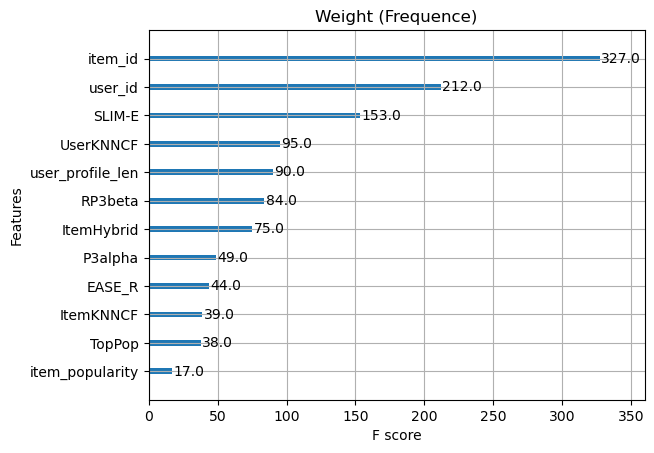

In [150]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [151]:
def cut(array, at=10):
    return np.argsort(array)[::-1][:at]

In [154]:
from Recommenders.BaseRecommender import BaseRecommender

In [167]:
class BohRecommender(BaseRecommender):
    def fit(self, XGB):
        self.XGB = XGB
    def recommend(self, user_id, cutoff=10, **kwargs):
        res = []
        for x in cut(self.XGB.predict(X_to_predict), cutoff):
            res.append(X_train[X_train["user_id"]==user_id]["item_id"][X_train[X_train["user_id"]==user_id]["item_id"].index[x]])
            
        return res

In [168]:
boh = BohRecommender(URM_train)

Recommender_Base_Class: URM Detected 523 ( 4.0%) users with no interactions.
Recommender_Base_Class: URM Detected 219 ( 1.0%) items with no interactions.


In [169]:
boh.fit(XGB_model)

In [170]:
result, _ = evaluator_test.evaluateRecommender(boh)
result.loc[10]

ValueError: ('Lengths must match to compare', (651250,), (1000,))

In [98]:
X_to_predict = X_train[X_train["user_id"] == 10]

XGB_model.predict(X_to_predict)

array([ 1.0525024 ,  0.6931635 ,  0.31613076,  0.4879189 ,  0.7825882 ,
       -0.14841728,  0.14535111,  0.36647776,  0.5036566 ,  0.17475817,
        0.71250683,  0.62847525,  0.39926475,  0.05171981,  0.4895998 ,
        0.17818108, -0.08979055,  0.01078345, -0.31097522, -0.32114303,
       -0.17068353, -0.61630565, -0.39364687, -0.2332153 , -0.37971154,
       -0.46723568, -0.80869436, -0.29756397, -0.17820723, -0.16792165],
      dtype=float32)

## Build models on the complete URM

In [71]:
slime_all = MultiThreadSLIM_SLIMElasticNetRecommender(URM_all)
slime_all.fit(l1_ratio=0.05223, alpha=0.00116885, topK=451)

SLIMElasticNetRecommender: URM Detected 387 ( 3.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 126 ( 0.6%) items with no interactions.


100%|██████████████████████████████████████████████████████████████████████████▉| 22344/22348 [02:58<00:00, 125.25it/s]


In [72]:
itemknncf_all = ItemKNNCFRecommender(URM_all)
itemknncf_all.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 387 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 126 ( 0.6%) items with no interactions.
Similarity column 22348 (100.0%), 10379.16 column/sec. Elapsed time 2.15 sec


In [73]:
p3alpha_all = P3alphaRecommender(URM_all)
p3alpha_all.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 387 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 126 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 5682.12 column/sec. Elapsed time 3.93 sec


In [74]:
rp3beta_all = RP3betaRecommender(URM_all)
rp3beta_all.fit(topK=25, alpha=0.26339, beta=0.20854, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 387 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 126 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 5670.56 column/sec. Elapsed time 3.94 sec


In [75]:
ease_all = EASE_R_Recommender(URM_all)
ease_all.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 387 ( 3.0%) users with no interactions.
EASE_R_Recommender: URM Detected 126 ( 0.6%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.46 min


In [76]:
userknncf_all = UserKNNCFRecommender(URM_all)
userknncf_all.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 387 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 126 ( 0.6%) items with no interactions.
Similarity column 13025 (100.0%), 8957.50 column/sec. Elapsed time 1.45 sec


In [79]:
sim1 = Compute_Similarity(URM_all, shrink = 9.803724, topK = 62, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_all, shrink = 6.736, topK = 3, similarity = 'jaccard').compute_similarity()
itemhybrid_all = ItemKNNSimilarityHybridRecommender(URM_all, sim1, sim2)
itemhybrid_all.fit(topK = 36, alpha = 0.267625)

Similarity column 22348 (100.0%), 10282.94 column/sec. Elapsed time 2.17 sec
Similarity column 22348 (100.0%), 9929.65 column/sec. Elapsed time 2.25 sec
ItemKNNSimilarityHybridRecommender: URM Detected 387 ( 3.0%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 126 ( 0.6%) items with no interactions.


In [80]:
recommender_all = ScoresHybridRecommender3(URM_all, slime, itemhybrid, rp3beta)
recommender_all.fit(alpha=0.661077, beta=0.144166)

ScoresHybridRecommender3: URM Detected 387 ( 3.0%) users with no interactions.
ScoresHybridRecommender3: URM Detected 126 ( 0.6%) items with no interactions.


In [81]:
topPop_all = TopPop(URM_all)
topPop_all.fit()

TopPopRecommender: URM Detected 387 ( 3.0%) users with no interactions.
TopPopRecommender: URM Detected 126 ( 0.6%) items with no interactions.


In [82]:
other_algorithms_all = {
    "TopPop": topPop_all,
    "ItemKNNCF": itemknncf_all,
    "P3alpha": p3alpha_all,
    "RP3beta": rp3beta_all,
    "SLIM-E": slime_all,
    "EASE_R": ease_all,
    "UserKNNCF": userknncf_all,
    "ItemHybrid": itemhybrid_all,
}

In [83]:
user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(target['user_id']):
    recommendations = recommender_all.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

100%|██████████████████████████████████████████████████████████████████████████| 10882/10882 [00:08<00:00, 1263.40it/s]


In [84]:
test_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})

In [85]:
test_dataframe = test_dataframe.set_index('user_id')

for user_id in tqdm(target['user_id']):
    for rec_label, rec_instance in other_algorithms_all.items():
        
        item_list = test_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "user_id"})

100%|███████████████████████████████████████████████████████████████████████████| 10882/10882 [00:34<00:00, 316.87it/s]


In [99]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["item_id"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["user_id"].values.astype(int)]

test_dataframe

,user_id,item_id,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,1,36,713.0,0.439743,0.593026,0.680395,0.610377,0.593840,21.718302,0.646958,713,44
1,1,101,426.0,0.479897,0.494574,0.594016,0.627155,0.481909,21.875183,0.813761,426,44
2,1,123,193.0,0.144487,0.226880,0.242852,0.448209,0.382725,5.670939,0.274542,193,44
3,1,403,131.0,0.503931,0.184924,0.226695,0.311231,0.274095,12.644982,0.445680,131,44
4,1,506,119.0,0.533700,0.130398,0.279060,0.393088,0.247785,10.563779,0.555201,119,44
...,...,...,...,...,...,...,...,...,...,...,...,...
326455,13024,464,126.0,0.137999,0.121003,0.185898,0.180337,0.131936,0.954991,0.287109,126,71
326456,13024,329,195.0,0.395758,0.038777,0.101987,0.134547,0.017730,13.241991,0.539088,195,71
326457,13024,11019,11.0,0.665549,0.123840,0.258476,0.253895,0.145207,5.985425,1.391520,11,71
326458,13024,410,150.0,0.226425,0.044570,0.113783,0.222708,0.186144,1.250641,0.264823,150,71


In [100]:
X = test_dataframe

In [101]:
predictions = XGB_model.predict(X)
predictions

array([ 0.6738808 ,  0.6219238 ,  0.27607703, ...,  0.35487825,
       -0.34369797, -0.27026796], dtype=float32)

In [102]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

,user_id,item_id,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
0,1,36,713.0,0.439743,0.593026,0.680395,0.610377,0.593840,21.718302,0.646958,713,44,0.673881
1,1,101,426.0,0.479897,0.494574,0.594016,0.627155,0.481909,21.875183,0.813761,426,44,0.621924
2,1,123,193.0,0.144487,0.226880,0.242852,0.448209,0.382725,5.670939,0.274542,193,44,0.276077
3,1,403,131.0,0.503931,0.184924,0.226695,0.311231,0.274095,12.644982,0.445680,131,44,0.127435
4,1,506,119.0,0.533700,0.130398,0.279060,0.393088,0.247785,10.563779,0.555201,119,44,0.289327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326455,13024,464,126.0,0.137999,0.121003,0.185898,0.180337,0.131936,0.954991,0.287109,126,71,-0.205596
326456,13024,329,195.0,0.395758,0.038777,0.101987,0.134547,0.017730,13.241991,0.539088,195,71,-0.240137
326457,13024,11019,11.0,0.665549,0.123840,0.258476,0.253895,0.145207,5.985425,1.391520,11,71,0.354878
326458,13024,410,150.0,0.226425,0.044570,0.113783,0.222708,0.186144,1.250641,0.264823,150,71,-0.343698


In [104]:
reranked_dataframe = reranked_dataframe.sort_values(['user_id','rating_xgb'], ascending=[True, False])
reranked_dataframe

,user_id,item_id,TopPop,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
5,1,515,97.0,0.500261,0.102181,0.276208,0.333997,0.283821,7.476872,0.473502,97,44,1.416169
0,1,36,713.0,0.439743,0.593026,0.680395,0.610377,0.593840,21.718302,0.646958,713,44,0.673881
1,1,101,426.0,0.479897,0.494574,0.594016,0.627155,0.481909,21.875183,0.813761,426,44,0.621924
4,1,506,119.0,0.533700,0.130398,0.279060,0.393088,0.247785,10.563779,0.555201,119,44,0.289327
2,1,123,193.0,0.144487,0.226880,0.242852,0.448209,0.382725,5.670939,0.274542,193,44,0.276077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326454,13024,1240,75.0,0.243063,0.000000,0.088398,0.255405,0.174513,9.203048,0.548179,75,71,-0.061915
326455,13024,464,126.0,0.137999,0.121003,0.185898,0.180337,0.131936,0.954991,0.287109,126,71,-0.205596
326456,13024,329,195.0,0.395758,0.038777,0.101987,0.134547,0.017730,13.241991,0.539088,195,71,-0.240137
326459,13024,22,802.0,0.232860,0.049714,0.119175,0.141004,0.021271,7.257642,0.231685,802,71,-0.270268


In [115]:
def reranked_recommendations():
    recommendations = 'user_id,item_list'
    f = open("Output/Reranked.csv", "w")

    for id in tqdm(target['user_id']):
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['user_id'] == id].item_id.values[:10]

        recommendation_string = str(id) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(rec) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [116]:
reranked_recommendations()

100%|██████████████████████████████████████████████████████████████████████████| 10882/10882 [00:03<00:00, 3205.94it/s]


In [118]:
noreranksubmission = pd.read_csv("Output/ScoresHybrid3new.csv")
submission = pd.read_csv("Output/Reranked.csv")

In [120]:
changed_item_count = 0

for user_id in submission['user_id']:
    default_items = noreranksubmission[noreranksubmission['user_id'] == user_id].item_list.values[0].split()
    reranked_items = submission[submission['user_id'] == user_id].item_list.values[0].split()
    
    new_items = list(set(reranked_items) - set(default_items))
    
    changed_item_count = changed_item_count + len(new_items)
    
n_users_to_recommend = len(target['user_id'])
n_recommended_items = n_users_to_recommend * 10

print("Changed {} items, {:.2f}% of total".format(changed_item_count, changed_item_count/n_recommended_items * 100))

Changed 32481 items, 29.85% of total


In [66]:
# Open the submission sample file
submission_sample = open('Input/data_target_users_test.csv', 'r')
type(submission_sample)

_io.TextIOWrapper

In [67]:
# Read the dataframe
target = pd.read_csv(filepath_or_buffer=submission_sample)
target

,user_id
0,1
1,2
2,3
3,4
4,5
...,...
10877,13020
10878,13021
10879,13022
10880,13023
